In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def count_para(model):
    total_para = 0
    for para in model.parameters():
        total_para += np.prod(para.size())
    return total_para

def show_imgs(imgs):
    sqrtn = int(np.ceil(np.sqrt(imgs.shape[0])))
    
    grid = torchvision.utils.make_grid(imgs , nrow=sqrtn , padding=2)
    fig = plt.figure(figsize=(sqrtn, sqrtn))

    ax = plt.subplot(1,1,1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.imshow(np.transpose(grid , (1,2,0)))
    plt.show()
    
def init_weights(m):
    if isinstance(m , nn.Linear) or isinstance(m , nn.ConvTranspose2d) or isinstance(m , nn.Conv2d):
        init.xavier_uniform_(m.weight.data)

In [3]:
class ChunkSampler(sampler.Sampler):
    def __init__(self , n , off=0):
        self.n = n
        self.off = off
        
    def __iter__(self):
        return iter(range(self.off , self.n + self.off))
    
    def __len__(self):
        return self.n

In [4]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
BATCH_SIZE = 128

mnist_train = dset.MNIST('./mnist/', train=True, download=True,
                           transform=T.ToTensor())

mnist_val = dset.MNIST('./mnist/', train=True, download=True,
                           transform=T.ToTensor())

loader_train = DataLoader(mnist_train, batch_size=BATCH_SIZE,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

loader_val = DataLoader(mnist_val, batch_size=BATCH_SIZE,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


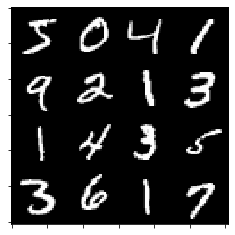

In [5]:
show_imgs(next(iter(loader_train))[0][0:16])

In [6]:
def sampler_noise(batch_size , dim):
    return torch.FloatTensor(batch_size , dim).uniform_(-1,1)

In [7]:
dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [9]:
def discriminator_loss(logits_real , logits_fake):
    N = logits_real.size(0)
    loss = (bce_loss(logits_real , torch.ones(N).type(dtype)) + bce_loss(logits_fake , torch.zeros(N).type(dtype)))
    return loss.mean()

def generator_loss(logits_fake):
    N = logits_fake.size(0)
    loss = bce_loss(logits_fake , torch.ones(N).type(dtype))
    return loss.mean()

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1 , 32 , kernel_size=5 , stride=1)
        self.conv2 = nn.Conv2d(32 , 64 , kernel_size=5 , stride=1)
        self.fc1 = nn.Linear(1024 , 1024)
        self.fc2 = nn.Linear(1024 , 1)
        
    def forward(self , x):
        x = x.view(BATCH_SIZE , 1 , 28 , 28)
        x = F.leaky_relu(self.conv1(x))
        x = F.max_pool2d(x , kernel_size=2 , stride=2)
        x = F.leaky_relu(self.conv2(x))
        x = F.max_pool2d(x , kernel_size=2 , stride=2)
        x = x.view(BATCH_SIZE , -1)
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(NOISE_DIM , 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024 , 6272)
        self.bn2 = nn.BatchNorm1d(6272)
        self.tconv1 = nn.ConvTranspose2d(128 , 64 , kernel_size=4 , stride=2 , padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64 , 1 , kernel_size=4 , stride=2 , padding=1)
        self.tanh = nn.Tanh()
        
    def forward(self , x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = x.view(BATCH_SIZE , 128 , 7 , 7)
        x = F.relu(self.tconv1(x))
        x = self.bn3(x)
        x = self.tanh(self.tconv2(x))
        return x.view(BATCH_SIZE , -1)        

In [11]:
G = Generator().type(dtype)
D = Discriminator().type(dtype)
G.apply(init_weights)
D.apply(init_weights)
G_optim = optim.Adam(G.parameters() , lr=1e-3)
D_optim = optim.Adam(D.parameters() , lr=1e-3)

In [12]:
M = G #D
t = 0
for p in M.parameters():
    t += np.prod(p.size())
t

6675009

In [13]:
def tran_GAN(D , G , D_optim , G_optim , D_loss , G_loss , show_every = 250 , n_epoch = 10):
    
    iter_cnt = 0
    for epoch in range(n_epoch):
        for X,_ in loader_train:
            if len(X) != BATCH_SIZE:
                continue
            D_optim.zero_grad()
            real_data = X.type(dtype)
            logits_real = D(2*(real_data - 0.5)).type(dtype)
            
            g_fake_seed = sampler_noise(BATCH_SIZE , NOISE_DIM).type(dtype)
            fake_imgs = G(g_fake_seed).detach()
            logits_fake = D(fake_imgs.view(BATCH_SIZE , 1 , 28 , 28))
            
            D_err = D_loss(logits_real , logits_fake)
            D_err.backward()
            D_optim.step()
            
            G_optim.zero_grad()
            g_fake_seed = sampler_noise(BATCH_SIZE, NOISE_DIM).type(dtype)
            fake_images = G(g_fake_seed)
            
            gen_logits_fake = D(fake_images.view(BATCH_SIZE , 1 , 28 , 28))
            G_err = G_loss(gen_logits_fake)
            G_err.backward()
            G_optim.step()
                
            if iter_cnt % show_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_cnt,D_err.item(),G_err.item()))
                imgs = fake_images.data.cpu()
                imgs = imgs.view(BATCH_SIZE , 1 , 28 , 28)
                show_imgs(imgs[0:16])
                print()
            iter_cnt += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 0, D: 1.404, G:0.7956


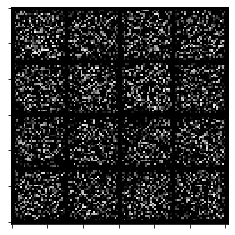

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 250, D: 0.6219, G:2.965


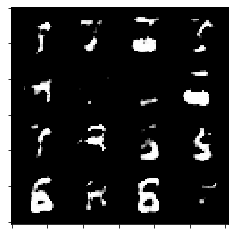

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 500, D: 0.6792, G:2.795


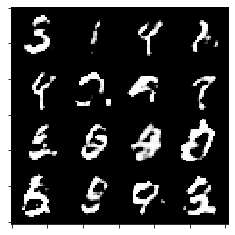

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 750, D: 0.6018, G:2.33


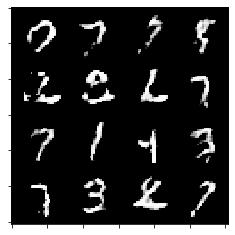

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 1000, D: 0.8943, G:1.489


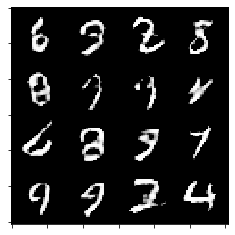

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 1250, D: 0.8908, G:1.774


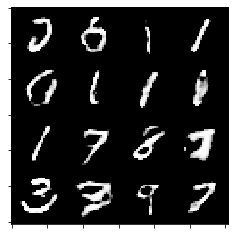

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 1500, D: 1.084, G:0.972


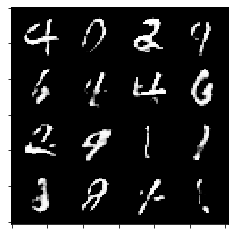

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 1750, D: 0.9766, G:1.568


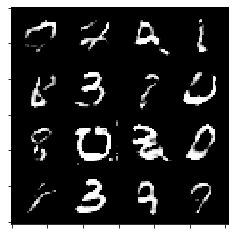

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 2000, D: 0.9217, G:1.322


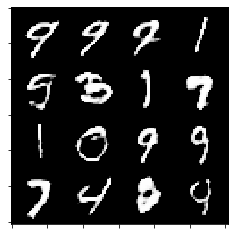

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 2250, D: 1.036, G:1.214


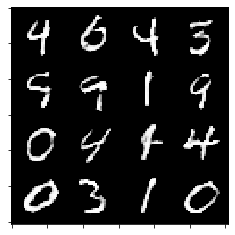

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 2500, D: 1.036, G:1.176


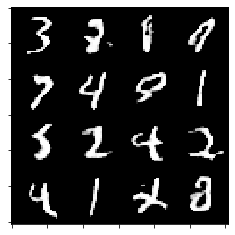

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 2750, D: 0.9311, G:1.243


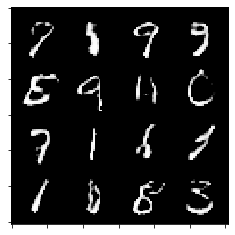

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 3000, D: 1.1, G:1.353


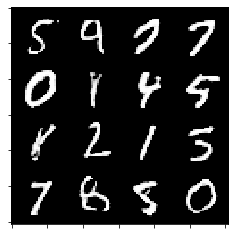

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 3250, D: 1.036, G:1.124


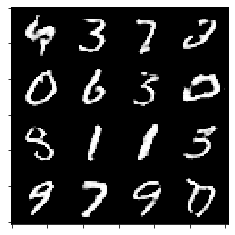

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 3500, D: 1.075, G:1.167


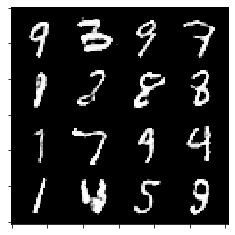

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iter: 3750, D: 0.8196, G:1.494


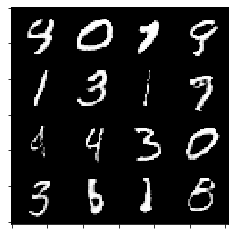

In [14]:
tran_GAN(D , G , D_optim , G_optim , discriminator_loss , generator_loss , show_every = 250 , n_epoch = 10)

In [16]:
torch.save(G.state_dict(), "G_weights_mnist.pt")
torch.save(D.state_dict(), "D_weights_mnist.pt")